# Doing Data Science using open national census data from the National Institute of Statistics and Geography (INEGI)
### by [Sarahí Aguilar González](https://twitter.com/svrvhi), [Luis Gerardo Canales Ocampo](https://twitter.com/LuisCanales__)and [Luz Mariana Blaz Carrillo](https://twitter.com/marianablueen)

## Abstract 

In Mexico, unfavorable sociodemographic conditions have increased the vulnerability of some sectors of the population to the impact of the covid-19 pandemic. Therefore, it is necessary to detect and make visible which sociodemographic factors are linked to higher rates of sars-cov2 infection and mortality, and thus to have a basis for generating public policies to reduce such vulnerability.

For this purpose, in this workshop we will use different mathematical methods such as linear regression by least squares and gradient boosting methods of variable selection and hypothesis testing applied to open data from covid-19 in Mexico and from the National Institute of Statistics and Geography (INEGI).

In this workshop we'll guide you through the Data Science development lifecycle to answer a research question using open national census data from the National Institute of Statistics and Geography (INEGI). 

## Getting started

For this workshop, we"ll be using the next libraries:

(Load them right away!)

In [ ]:
from google.colab import drive 
import os

import pandas as pd
import numpy as np

import seaborn as sns
sns.set_theme(style="ticks")
import matplotlib.pyplot as plt
%matplotlib inline
!pip install --upgrade geopandas plotly
import geopandas as gpd
import plotly.express as px

from scipy.special import logit, expit
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_regression
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as MSE
import xgboost as xg

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data gathering




We'll be working with three open datasets:



1.   **Daily covid-19 positive cases by municipality from the 
General Directorate of Epidemiology (known is spanish as DGE)*** 
2.   **Daily covid-19 deaths by municipality from the 
General Directorate of Epidemiology (known is spanish as DGE)***
3.   **National census data from the National Institute of Statistics and Geography (known is spanish as  INEGI)**

*Positive cases are the set of cases that have a positive sample result or that are classified as positive by epidemiological association or by ruling (only for deaths).

#### Download the datasets


In the the [data folder](https://drive.google.com/drive/folders/1HhNd5JpxbF5YF2Po46cd9VgAOyt2xbt-?usp=sharing) you'll already find these three datasets, but you can always download them by yourself too...

*  You'll find datasets 1 and 2 available for download [here](https://datos.covid-19.conacyt.mx/#DownZCSV). (Note that values may be updated over time. The datasets found in the [data folder](https://drive.google.com/drive/folders/1HhNd5JpxbF5YF2Po46cd9VgAOyt2xbt-?usp=sharing).)  
*  You'll find dataset 3 available for download [here](https://inegi.org.mx/programas/ccpv/2020/#Datos_abiertos).

Before downloading any dataset, we strongly recommend to always get familiar with the nature of the dataset itself. For that, be sure to read avilable documentation and methodological frameworks. 

#### Load data into development environment

For this stage, we'll be loading it directly from our personal Google Drive unit by mounting it to our Google Collab development environment. This means you'll be able to load any file that is stored in your Google Drive unit into this notebook. 



In [ ]:
drive.mount('/content/drive') 
# Then, go to the provided link, copy authorization code, paste authorization code in box below and press Enter

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Change working directory to our personal Google Drive unit
os.chdir('/content/drive/MyDrive')

In [ ]:
# Set variable with folder where datasets are stored
DATA_PATH = 'RIIA 4.0 Workshop - DSci & INEGI/datos/'

# Set variables with the filepath of each dataset
casos_path = DATA_PATH + 'Casos_Diarios_Municipio_Confirmados_20210820.csv'
fallec_path = DATA_PATH + 'Casos_Diarios_Municipio_Defunciones_20210811.csv'
censo_path = DATA_PATH + 'conjunto_de_datos_iter_00CSV20.csv'

In [ ]:
# Load each dataset
df_covid_casos = pd.read_csv(casos_path) # Daily covid-19 positive cases by municipality
df_covid_fallec = pd.read_csv(fallec_path) # Daily covid-19 deaths by municipality
df_censo = pd.read_csv(censo_path) # National census data 

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Exploratory analysis & data wrangling

#### Covid-19 cases by municipality

In [ ]:
# Print first 10 rows of dataset for quick view
df_covid_casos.head(10)

cve_ent  poblacion         nombre  ...  18-08-2021  19-08-2021  20-08-2021
0    16046      15290         Juarez  ...           0           0           0
1    16047      22358       Jungapeo  ...           0           0           0
2    16048       5862     Lagunillas  ...           1           0           0
3    16049      18769         Madero  ...           0           0           0
4     5035     744247        Torreon  ...          28           3           0
5     5036      23781         Viesca  ...           0           0           0
6     7012      56971    Berriozabal  ...           0           1           0
7    11038      12978    Tarandacuao  ...           0           0           0
8    11039      36574       Tarimoro  ...           5           2           0
9    11040      20238  Tierra Blanca  ...           2           2           0

[10 rows x 553 columns]

In [ ]:
# Print dimensions of dataset
df_covid_casos.shape

(2457, 553)

In [ ]:
# Print column names of dataset
df_covid_casos.columns

Index(['cve_ent', 'poblacion', 'nombre', '18-02-2020', '19-02-2020',
       '20-02-2020', '21-02-2020', '22-02-2020', '23-02-2020', '24-02-2020',
       ...
       '11-08-2021', '12-08-2021', '13-08-2021', '14-08-2021', '15-08-2021',
       '16-08-2021', '17-08-2021', '18-08-2021', '19-08-2021', '20-08-2021'],
      dtype='object', length=553)

In [ ]:
# Print unique values of cve_ent column
np.unique(df_covid_casos.cve_ent.values)

array([ 1001,  1002,  1003, ..., 32056, 32057, 32058])

Notice that... 
*   each row is a municipality and each column is a day
*   `cve_ent` variable contains a unique identifier for each municipality composed by a state number and a municipality number



To create letality variable later on, we'll have to first create a variable in this dataset with the sum of all covid-19 positive cases in 2020.

In [ ]:
# Selects all column with "-2020" pattern in its name and sums its values
df_covid_casos["covid_casos_2020"] = df_covid_casos.filter(regex="-2020").sum(axis=1)

In [ ]:
# Print minimum and maximum value of covid_casos_2020 column
min(df_covid_casos.covid_casos_2020.values), max(df_covid_casos.covid_casos_2020.values)

(0, 52837)

Notice that there are some municipalities with 0 covid-19 positive cases. We have to delete those cases; otherwise, when calculating letality later on, we'll get error values.

In [ ]:
 df_covid_casos.query("covid_casos_2020 > 0", inplace=True)

For easier manipulation later on, we make `cve_ent` variable the dataset's index and only keep our two relevant variables in the dataset. 

In [ ]:
df_covid_casos = df_covid_casos[["cve_ent", "covid_casos_2020"]].set_index("cve_ent")

#### Covid-19 deaths by municipality

In [ ]:
df_covid_fallec.head(10)

cve_ent  poblacion         nombre  ...  09-08-2021  10-08-2021  11-08-2021
0    16046      15290         Juarez  ...           0           1           0
1    16047      22358       Jungapeo  ...           0           0           0
2    16048       5862     Lagunillas  ...           0           0           0
3    16049      18769         Madero  ...           0           0           0
4     5035     744247        Torreon  ...           2           0           0
5     5036      23781         Viesca  ...           0           0           0
6     7012      56971    Berriozabal  ...           0           0           0
7    11038      12978    Tarandacuao  ...           0           0           0
8    11039      36574       Tarimoro  ...           0           0           0
9    11040      20238  Tierra Blanca  ...           0           0           0

[10 rows x 516 columns]

In [ ]:
# Print dimensions of dataset
df_covid_fallec.shape

(2457, 516)

In [ ]:
df_covid_fallec.columns

Index(['cve_ent', 'poblacion', 'nombre', '17-03-2020', '18-03-2020',
       '19-03-2020', '20-03-2020', '21-03-2020', '22-03-2020', '23-03-2020',
       ...
       '02-08-2021', '03-08-2021', '04-08-2021', '05-08-2021', '06-08-2021',
       '07-08-2021', '08-08-2021', '09-08-2021', '10-08-2021', '11-08-2021'],
      dtype='object', length=516)

In [ ]:
np.unique(df_covid_fallec.cve_ent.values)

array([ 1001,  1002,  1003, ..., 32056, 32057, 32058])

Notice that the dataset of daily covid-19 deaths by municipality and daily covid-19 deaths by municipality have the same structure.



To create letality variable later on, just as in last dataset, we'll have to first create a variable in this dataset with the sum of all covid-19 deaths in 2020.

In [ ]:
# Selects all column with "-2020" pattern in its name and sums its values
df_covid_fallec["covid_fallec_2020"] = df_covid_fallec.filter(regex="-2020").sum(axis=1)

For easier manipulation later on, we make `cve_ent` variable the dataset's index and only keep our two relevant variables in the dataset. 

In [ ]:
df_covid_fallec = df_covid_fallec[["cve_ent", "covid_fallec_2020"]].set_index("cve_ent")

#### Creating letality variable (dependant variable)

For this step, we'll have to merge the covid-19 cases by municipality dataset and covid-19 deaths by municipality dataset. We'll do this with the unique identifier of municipalities (`cve_ent` variable) and by keeping all rows of the second dataset.

In [ ]:
df_letalidad = pd.merge(df_covid_fallec, df_covid_casos, on="cve_ent", how="right")

We'll know create a new variable for letatily, defined as: 

$letality=\frac{\text{Total covid deaths}}{\text{Total positive cases}}$




In [ ]:
df_letalidad['letalidad'] = df_letalidad.covid_fallec_2020/df_letalidad.covid_casos_2020
df_letalidad.dropna(axis=0, inplace=True) # Delete NA's

In [ ]:
# Drop irrelevant columns now that we have letality variable calculated
columns_to_drop = ["covid_fallec_2020", "covid_casos_2020"]
df_letalidad.drop(columns_to_drop, axis=1, inplace=True)

#### National census

In [ ]:
df_censo.head(10)

ENTIDAD         NOM_ENT  MUN  ... VPH_SINCINT  VPH_SINTIC TAMLOC
0        0  Total nacional    0  ...    15108204      852871      *
1        0  Total nacional    0  ...       51293        7154      *
2        0  Total nacional    0  ...       29741        5283      *
3        1  Aguascalientes    0  ...      128996        1711      *
4        1  Aguascalientes    0  ...         530          20      *
5        1  Aguascalientes    0  ...         330          11      *
6        1  Aguascalientes    1  ...       74227         731      *
7        1  Aguascalientes    1  ...       63661         595     13
8        1  Aguascalientes    1  ...           *           *      1
9        1  Aguascalientes    1  ...           6           0      1

[10 rows x 232 columns]

Notice that the dataset already contains aggregated data by row in diffent levels. We'll use aggregated data by municipality. 

In [ ]:
# Filters all rows with aggregated data by municipality
df_censo_mun = df_censo.query("NOM_LOC == 'Total del Municipio'")

In [ ]:
df_censo_mun.shape

(2469, 232)

Variables on this dataset don't have intuitive names. Get familiarized with them by taking a look to the dataset's dictionary also available in the [data folder](https://drive.google.com/file/d/1QoWSKfMFsP5A8SaMkR2j59gYhA-AxFpv/view?usp=sharing) or for download [here](https://datos.covid-19.conacyt.mx/#DownZCSV)

Notice that this dataset doesn't contain the unique identifier for each municipality that the other datasets had. Therefore, we have to transform two variables to get that same unique identifier. 

In [ ]:
df_censo_mun["cve_ent"] = df_censo_mun.ENTIDAD * 1000 + df_censo_mun.MUN
# Trust us, this transformation does the job!

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


For easier manipulation later on, we make cve_ent variable the dataset's index.

In [ ]:
df_censo_mun.set_index("cve_ent", inplace=True)

### Merging independant variables (census data) and dependant variable (letality)

For this step, we'll have to merge the dataset that contained the letality variable and the national census dataset. We'll do this with the unique identifier of municipalities (`cve_ent` variable) and by keeping all rows of the second dataset.

In [ ]:
df = pd.merge(df_censo_mun, df_letalidad, on="cve_ent", how="right")

In [ ]:
# Drop irrelevant columns 
columns_to_drop = ["NOM_ENT", "NOM_MUN", "ENTIDAD", "MUN", "LOC", "NOM_LOC", "LONGITUD", "LATITUD", "ALTITUD", "TAMLOC"]
df.drop(columns_to_drop, axis=1, inplace=True)

We now have our first final dataset. Let's import it and reload it.

In [ ]:
# df.to_csv(DATA_PATH + "letalidad_covid_munic_mx.scv")

In [ ]:
# df = pd.read_csv(DATA_PATH + "letalidad_covid_munic_mx.scv")
# df.set_index("cve_ent", inplace=True)

### Exploratory analysis

In [ ]:
# Convert all columns to a numeric type
cols_to_numeric = df.columns
df[cols_to_numeric] = df[cols_to_numeric].apply(pd.to_numeric, errors="coerce")

In [ ]:
# Get a brief description of each variable
df.describe()

POBTOT         POBFEM  ...    VPH_SINTIC    letalidad
count  2.311000e+03    2311.000000  ...   2311.000000  2311.000000
mean   5.427550e+04   27799.127218  ...    360.296408     0.169931
std    1.513703e+05   77448.110882  ...    661.405713     0.166368
min    8.100000e+01      40.000000  ...      0.000000     0.000000
25%    5.402500e+03    2747.500000  ...     60.000000     0.064894
50%    1.517500e+04    7763.000000  ...    159.000000     0.133333
75%    3.787600e+04   19423.000000  ...    406.000000     0.224994
max    1.922523e+06  953783.000000  ...  15652.000000     1.000000

[8 rows x 223 columns]

Text(0.5, 1.0, "Distribution of covid-19 letality in Mexico's municipalities")

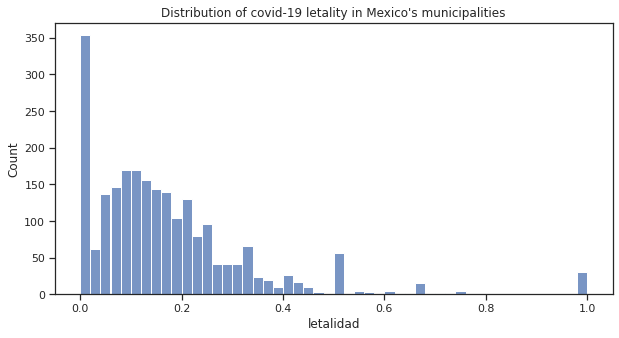

In [ ]:
# Plot distribution of our dependant variable
plt.figure(figsize=(10,5))
p = sns.histplot(data=df, x="letalidad", bins=50)
p.set_title("Distribution of covid-19 letality in Mexico's municipalities")

In [ ]:
edomex_shp = gpd.read_file('/content/drive/MyDrive/RIIA 4.0 Workshop - DSci & INEGI/shapes/15mun.shp')
edomex_shp.set_index("CVEGEO", inplace=True)

edomex_shp.drop(["CVE_ENT", "CVE_MUN"], axis=1, inplace=True)
edomex_shp.index = [int(cve) for cve in edomex_shp.index]

# df.index.set_names("CVEGEO", inplace=True)
edomex_shp.index.set_names("cve_ent", inplace=True)

edomex_gpd = edomex_shp.merge(df, on="cve_ent", how="left")

# WGS 84 coordenates
edomex_gpd.to_crs(epsg=4326, inplace=True)

# Plot
fig = px.choropleth(edomex_gpd, locations=edomex_gpd.index, geojson=edomex_gpd.geometry, color="letalidad", hover_name="NOMGEO")
fig.update_geos(fitbounds="locations", visible=False)

fig.show()

❗ **Your turn**

What can you tell about the distribution of covid-19 letality in Mexico's municipalities?

Can you identify which municipality has the higuest covid-19 letality?

Check the distribution of some other census data variables.

How does other census data variables correlate with covid-19 letality?

Can we model covid-19 letality using this data already?


### Normalization & scaling

Notice that most of the census data variables will be highly correlated to a *broader* variable in the dataset. For instance, `POBFEM` and `POBMAS` variales, which indicate the female population and male population of the municipality respectively, will be highly correlated to `POBTOT`, which indicates the total population of the municipality. 



❗ **Your turn**

Can you find the *broadest* variables in the dataset by looking at the dataset's dictionary?

In total, there are four *global* variables in the census data: `POBTOT`, `TOTHOG`, `POBHOG` and `VIVTOT`. The rest* of the variables will be highly correlated to any of these.

*With the exception of those variables that are an avarage (`PROM_HNV`, `GRAPROES`, `GRAPROES_F`, `GRAPROES_M`, `PROM_OCUP` and `PRO_OCUP_C`).

In the the [data folder](https://drive.google.com/drive/folders/1HhNd5JpxbF5YF2Po46cd9VgAOyt2xbt-?usp=sharing) you'll find a [csv](https://drive.google.com/file/d/1D43HDeFMDBN88_UawRoEQBu_H7MOR6Uw/view?usp=sharing) with all these relationships stated. In this csv, each column name is the name of each of these four *global* variables and the values of each column are the variables that are highly correlated to each of the four *global* variables.

**In order to reduce redundancy and to make census data more logical and easier to compare within municipalities, we have to go through a normalization process of two steps.** 

#### First step

This first step consists in transforming each census data variable into a ratio. We can do this by dividing each variable by its respective *global* variable. And, to automate this in a few lines, we can use the [csv](https://drive.google.com/file/d/1D43HDeFMDBN88_UawRoEQBu_H7MOR6Uw/view?usp=sharing) we just mentioned.

In [ ]:
# Read csv
NORM_PATH = DATA_PATH + 'dict_to_norm.csv'
dict_norm = pd.read_csv(NORM_PATH)

In [ ]:
# Make a copy of our original dataset
df_norm = df.copy()

# Iterate through each four global variables in the census data
for col in dict_norm.columns:
  tmp = dict_norm[col].dropna()
  df_norm[tmp] = df_norm[tmp].divide(df_norm[col], axis=0)

# Drop global variables
df_norm.drop(columns=dict_norm.columns, inplace=True)

NameError: ignored

#### Second step

For the second step, we'll make sure all values in the dataset are naturally restricted to be in the range 0 to 1, not including the end-points. For this, a logit transformation may be appropriate, which yields values in the range (−∞,∞).

In [ ]:
# Create empty dataframe
df_logit = pd.DataFrame()

# Iterate through each column of the dataset to tranform and get the logit of each value
for column in df_norm.columns:
  df_logit[column] = logit(df_norm[column].clip(0.001, .999))

❗ **Your turn**

What implications arise when transforming data?

How does the distribution of covid-19 letality in Mexico's municipalities now looks like?

What's the importnace of normalization and scaling before modeling?

We now have our final dataset normalized and scaled. Let's import it and reload it.

In [ ]:
# df_logit.to_csv(DATA_PATH + "letalidad_covid_munic_mx_norm.csv")

In [ ]:
# df_logit = pd.read_csv(DATA_PATH + "letalidad_covid_munic_mx_norm.csv")
# df_logit.set_index("cve_ent", inplace=True)

### Minimizing natural variability 

Now that we are getting closer to having a final dataset to model with, let's evaluate if there are still chances to reduce redudancy in our data...

We know since the beginning of the covid-19 pandemic in Mexico that there were important [differences in the way that each state in Mexico dealed with it and its consequences](https://www.eleconomista.com.mx/politica/Como-enfrenta-cada-entidad-de-Mexico-la-epidemia-del-Covid-19-20200427-0170.html). 

In the next graph, we tried to quickly evaluate if there important differences in the data of the municipalities of each state. 

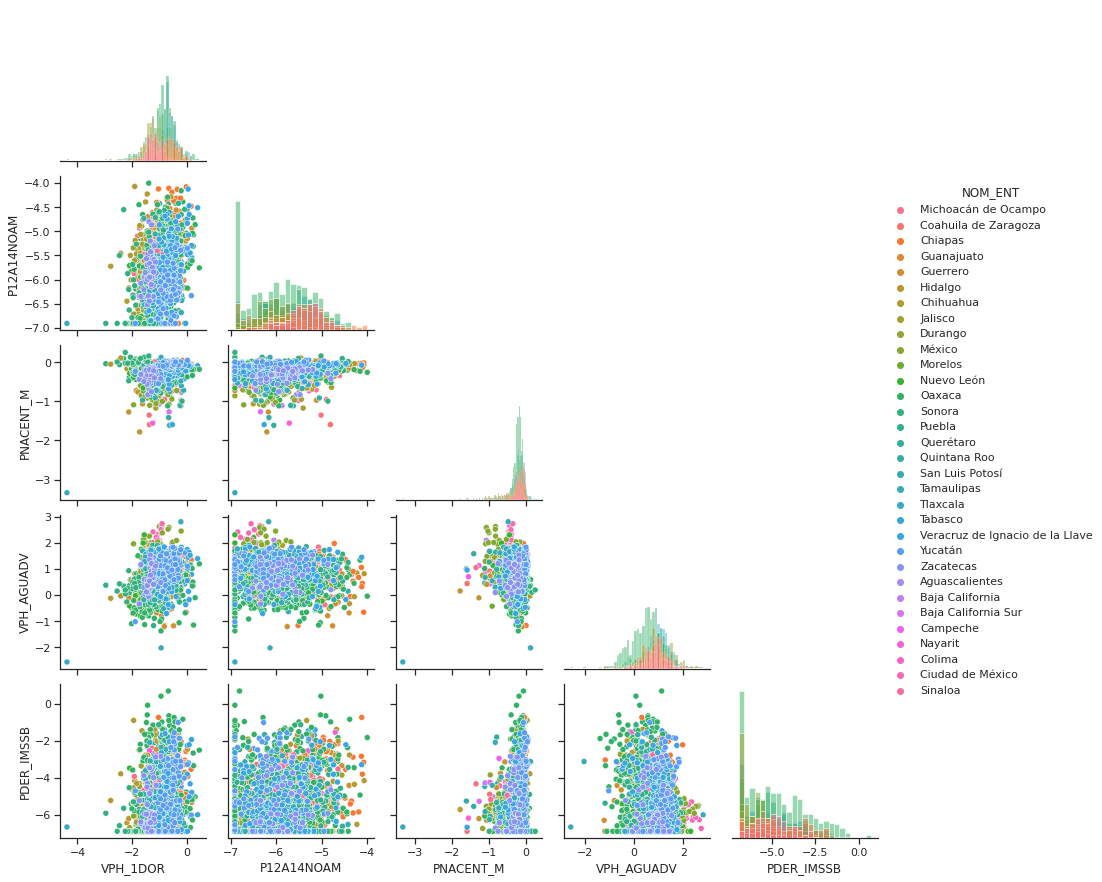

In [ ]:
# Warning: This graph may take a while to render. Make sure to only select <=10 variables to plot. 
g = sns.PairGrid(data=pd.merge(df_censo_mun[["NOM_ENT"]], df_logit[["VPH_1DOR", "P12A14NOAM", "PNACENT_M", "VPH_AGUADV", "PDER_IMSSB"]], on="cve_ent", how="right"), 
                 hue="NOM_ENT", 
                 corner=True)
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot)
g.add_legend()

❗ Your turn

Evaluate how other variables look in the municipalities of each state.

What implications may arise if we build a model using the municipalities of all states?

We chose to model using only data of one single state: State of Mexico.  

In [ ]:
# Select rows only with index within State of Mexico encoding
df_edomex = df_logit.loc[(df_logit.index > 15000) & (16000 > df_logit.index)]

In [ ]:
df_edomex.shape

(125, 219)

In [ ]:
df_edomex.head()

POBFEM    POBMAS     P_0A2  ...  VPH_SINCINT  VPH_SINTIC  letalidad
cve_ent                                ...                                    
15021    0.078865 -0.078865 -2.621393  ...     0.298368   -3.400871  -2.871680
15029    0.063384 -0.063384 -3.155459  ...    -1.038799   -5.346462  -1.743297
15075    0.044281 -0.044281 -3.063204  ...    -0.227129   -4.383503  -2.027173
15115    0.040897 -0.040897 -2.987518  ...    -0.404262   -4.609555  -1.581389
15051    0.028077 -0.028077 -3.055967  ...    -0.673638   -4.736579  -1.628636

[5 rows x 219 columns]

## Feature selection

Let's remember the assumptions of a simple linear regression...

*   Linear relationship
*   Multivariate normality
*   No or little multicollinearity
*   No auto-correlation
*   Homoscedasticity



❗ Your turn

Which of this assumptions have we already covered?

What implications arise when modeling with many variables (sometimes even unknown variables)?

What implications arise when modeling with hand-picked variables?



#### Feature importance

For this step, we first estimated the importance of the variables in our dataset using mutual information for letality. 

Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

Additional resources:

*   [Mutual Information on Wikipedia](https://en.wikipedia.org/wiki/Mutual_information)
*   A. Kraskov, H. Stogbauer and P. Grassberger, "Estimating mutual information". Phys. Rev. E 69, 2004.



We'll use scikit-learn's `SelectKBest` with mutual information score function.

In order to automate this process and be able to quickly try other  scikit-learn's score functions (aside from mutual information) for feature selection, we built the next function.

In [ ]:
def select_features(X_train, y_train, X_test, sf):
	# Configure to select all features
	fs = SelectKBest(score_func=sf, k='all')
 
	# Learn relationship from training data
	fs.fit(X_train, y_train)
 
	# Transform train input data
	X_train_fs = fs.transform(X_train)
 
	# Transform test input data
	X_test_fs = fs.transform(X_test)
 
	return X_train_fs, X_test_fs, fs

In [ ]:
# Define X (independant variable) and y (dependant variable)
X = df_edomex.drop(["letalidad"], axis=1).to_numpy(dtype=float)
y = df_edomex.letalidad.values

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [ ]:
# Feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, mutual_info_regression)

In [ ]:
# Create a series with the importances 
importances = pd.Series(fs.scores_, df_edomex.columns[:len(fs.scores_)])
importances.sort_values(ascending=False, inplace=True)

Let's look and study the top 15 most important features. 

In [ ]:
top_15_features = importances.head(15)
display(top_15_features)

VPH_1DOR      0.210308
P12A14NOAM    0.203186
PNACENT_M     0.193583
VPH_AGUADV    0.174248
PEA           0.169950
PDER_IMSSB    0.165176
PNACENT_F     0.160714
P_5YMAS_F     0.160140
P_12A14_M     0.159520
POCUPADA      0.159487
P_15YMAS      0.151930
P15YM_AN      0.144812
P_60YMAS_F    0.142145
PCATOLICA     0.140770
P18YM_PB      0.135829
dtype: float64

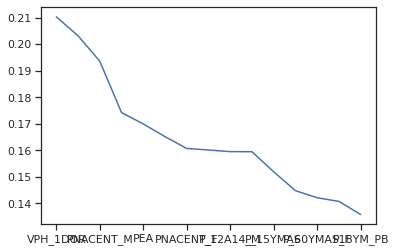

In [ ]:
top_15_features.plot()

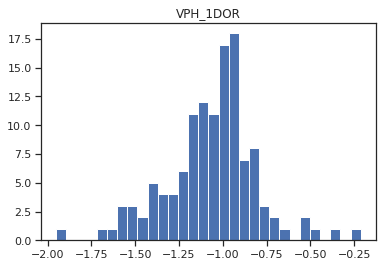

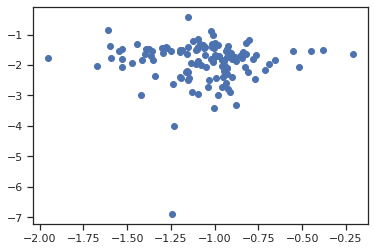

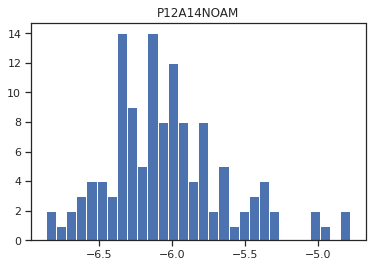

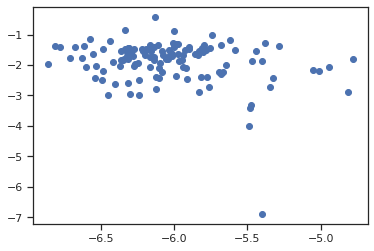

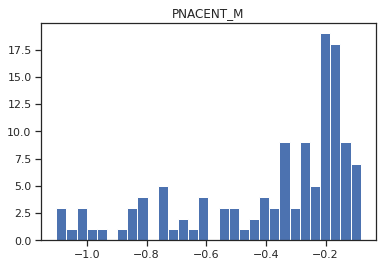

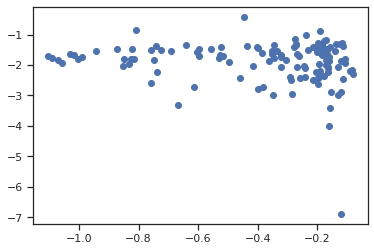

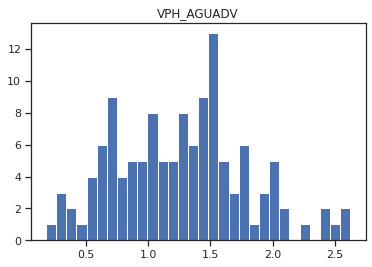

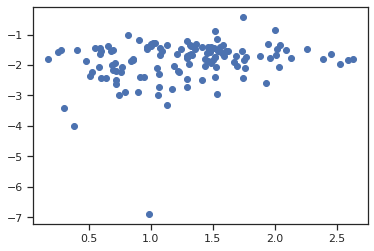

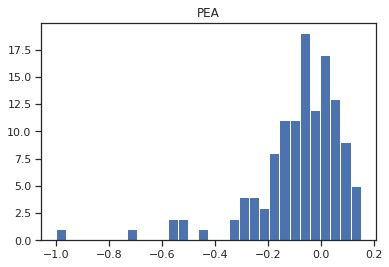

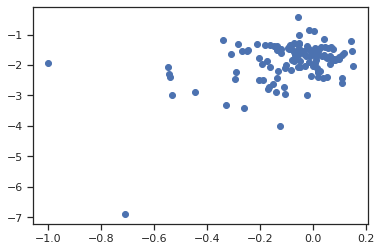

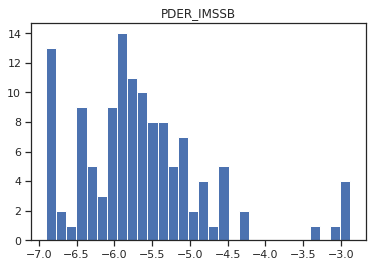

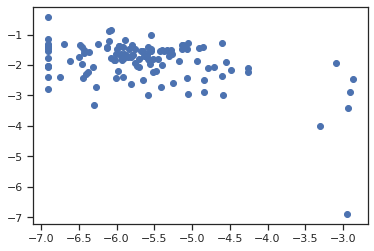

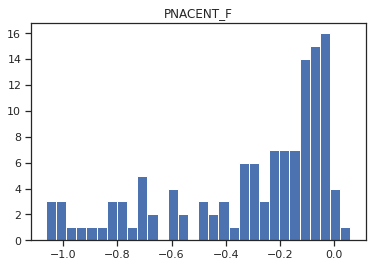

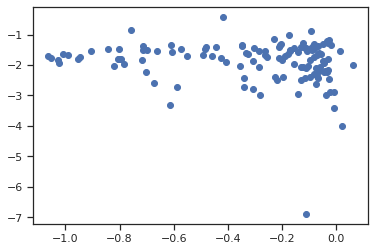

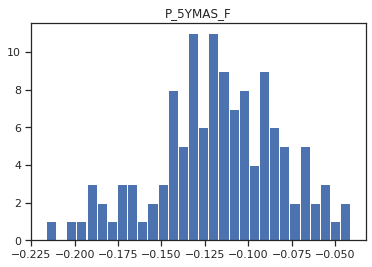

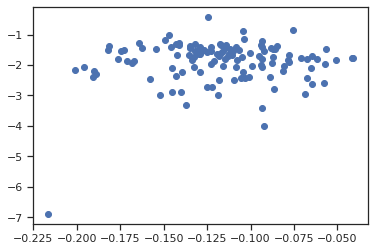

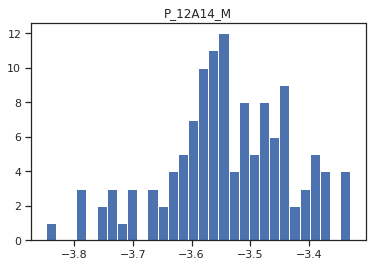

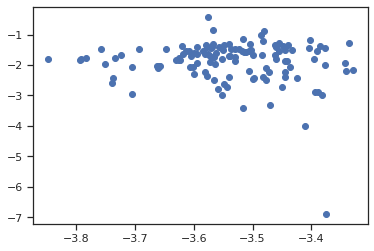

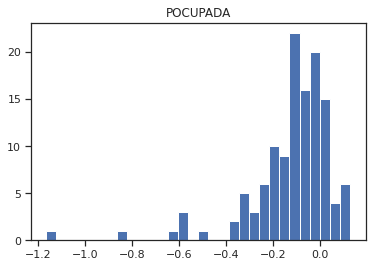

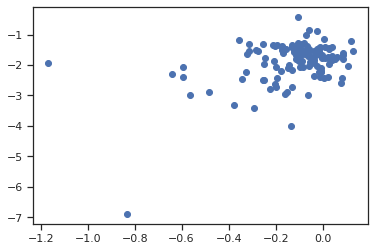

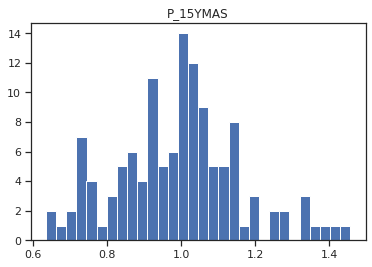

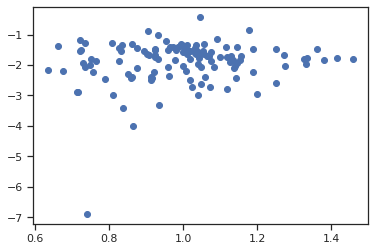

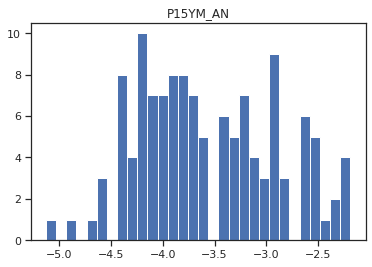

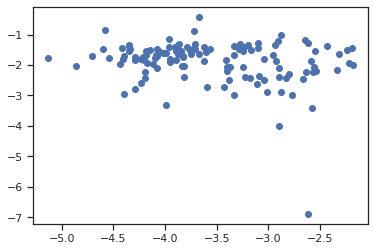

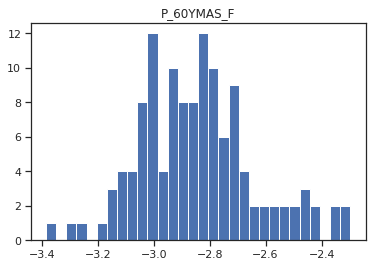

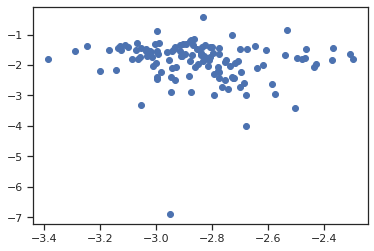

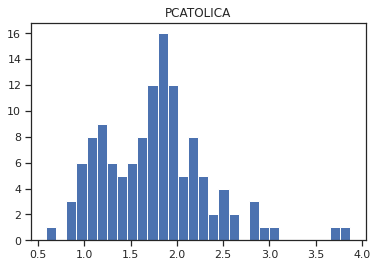

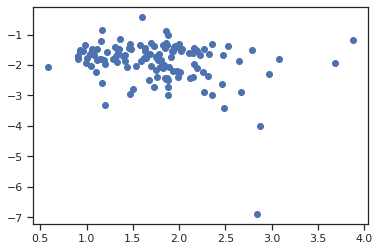

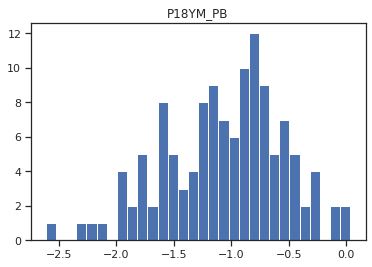

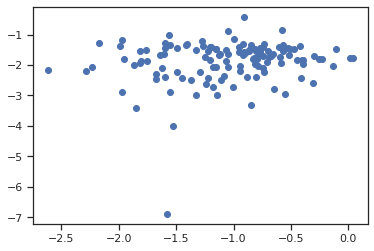

In [ ]:
for ind in top_15_features.index:
  plt.hist(df_edomex[ind], bins=30) # Print histogram 
  plt.title(ind)
  plt.show()
  plt.scatter(df_edomex[ind], df_edomex['letalidad']) # Print scatterplot against our dependant variable
  plt.show()

❗ Your turn

Try using another score function to get the feature importances of our dataset.

Which of this assumptions have we already covered?

What can you tell about the top 15 most important features?

How would you choose which features we can start modeling with?


#### Selecting non-correlated features

Simply by reading the names of our top 15 most important features, we can realize that the correlation between some of them are correlated and we can confirm this by looking at a correlation matrix.

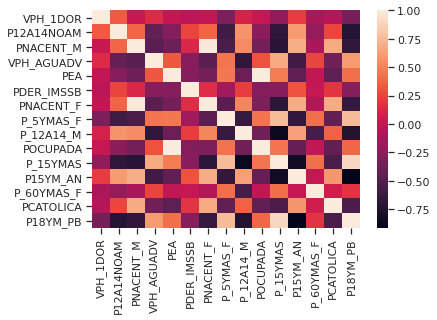

In [ ]:
corr_mt = df_edomex[top_15_features.index.values].corr()
sns.heatmap(corr_mt)

In order to avoid using correlated features, we first looked at all those features with a correlation coefficient above 0.75 and only kept the variable with the highest importance (previosluy calculated). 

In order to automate this in a few lines, we build the next functions.

In [ ]:
def top_features(imps, n):
  top_features = imps.head(n).index
  top_features = np.append(top_features, "letalidad")

  return top_features

In [ ]:
def drop_correlated(df, imps, n): 
  tf = top_features(imps, n)
  df_norm_model = df[tf]
  corr_mt = df_norm_model.corr()

  to_drop = np.array([])
  for col in corr_mt.columns:
    if col not in to_drop:
      series = corr_mt[col]
      series = series[(np.abs(series)>0.75) & (series.index != col)]
      to_drop = np.append(to_drop,series.index.to_numpy())
      
  return df_norm_model.drop(to_drop, axis=1)

In [ ]:
df_model = drop_correlated(df_edomex, importances, 120)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


By using the top 120 most important features, we get 40 non-correlated features. 

In [ ]:
df_model.head()

VPH_1DOR  P12A14NOAM  PNACENT_M  ...  VPH_MOTO  P3YM_HLI_F  letalidad
cve_ent                                   ...                                 
15021   -1.129890   -4.814247  -0.155424  ... -1.858891   -6.906755  -2.871680
15029   -0.882249   -6.167467  -0.989713  ... -2.008927   -5.201256  -1.743297
15075   -0.958089   -6.367569  -0.414869  ... -2.063030   -5.409308  -2.027173
15115   -1.195584   -6.321630  -0.201991  ... -3.035743   -4.958596  -1.581389
15051   -1.396935   -6.555116  -0.353347  ... -2.648083   -5.099170  -1.628636

[5 rows x 41 columns]

In [ ]:
df_model.shape

(125, 41)

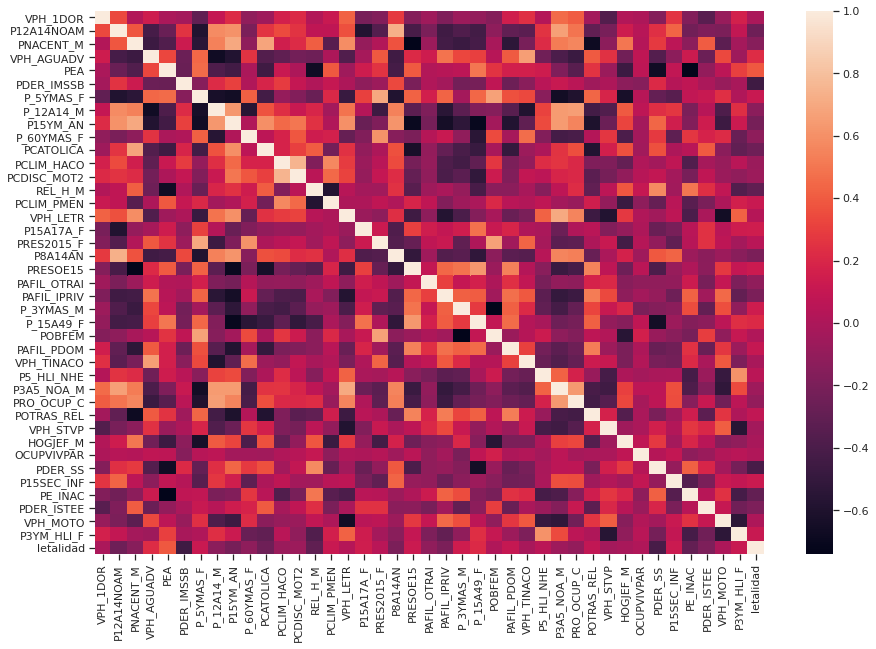

In [ ]:
plt.figure(figsize=(15,10))
corr_mt = df_model.corr()
sns.heatmap(corr_mt)